                                                 TP TANO ASSANDE JACOB
                                       Etudiant en master II data science big data

In [1]:
import findspark
findspark.init()
import pandas as pd
from pyspark.sql import SparkSession
import os

try:
    os.remove("metastore_db/db.lck")
    os.remove("metastore_db/dbex.lck")
except:
    pass


from pyspark.sql import SparkSession

def build_spark_session(app_name, memory='4g', executors=4):
    return SparkSession.builder\
                      .appName(app_name)\
                      .config('spark.executor.memory', memory)\
                      .config('spark.executor.instances', executors)\
                      .getOrCreate()

spark_session = build_spark_session(app_name='ok-google')

from pyspark.sql import functions as f

1 - joindre les dataframe sur la clé ID_CLIENT en concervant tous les clients du périmètre.
2 - compter le nombre de ID_CLIENT et vérifier qu'il correspond aux nombre d'ID_CLIENT dans la variable perimètre.
3 - Caster les variables continues en double et sauvergarder alors le df obtenu dans le repertoire data sur le cluster.
4 - Pour les variables catégorielles, créer une nouvelle variable qui prend la modalité de la variable courante si elle existe et "NA" sinon.
5- Verifier la cohérence des variables continue. Par exemple pour une variable comme age mettre à -1 tous les ages <0 ou>120ans

- #### Reading of our data files

In [2]:
perimetre = spark_session.read.csv("E:/MASTER2 DS-BD/SPARK/data_clients/sample_perimetre.csv", header=True)
histo_client_raw = spark_session.read.csv("E:/MASTER2 DS-BD/SPARK/data_clients/sample_histo_client.csv", header=True)
histo_train_raw = spark_session.read.csv("E:/MASTER2 DS-BD/SPARK/data_clients/sample_histo_train.csv", header=True)
histo_lowcost_raw = spark_session.read.csv("E:/MASTER2 DS-BD/SPARK/data_clients/sample_histo_lowcost.csv", header=True)
visites_raw = spark_session.read.csv("E:/MASTER2 DS-BD/SPARK/data_clients/sample_visites.csv", header=True)

- #### writing a function to cast continuous features in double 

In [3]:
##("anciennete", "recence_cmd", "AGE", etc..) in float

client_cols_to_keep = ["ID_CLIENT", 'LBL_STATUT_CLT','LBL_GEO_AIR',
            'LBL_SEG_COMPORTEMENTAL','LBL_GEO_TRAIN','LBL_GRP_SEGMENT_NL',
            'LBL_SEGMENT_ANTICIPATION','FLG_CMD_CARTE_1225']

def cast_columns_of_df(df, cols_to_cast, col_to_keep, cast_type='double'):
    """cast continuous columns into double since all columns are """
    return df.select(col_to_keep + [(df[feature].cast(cast_type))
                    for feature in cols_to_cast if 'ID_CLIENT' not in feature]) 

- #### Using of our function to cast contnuous features in double

In [4]:
histo_train = cast_columns_of_df(histo_train_raw, histo_train_raw.columns,["ID_CLIENT"], cast_type='double')

histo_lowcost = cast_columns_of_df(histo_lowcost_raw, histo_lowcost_raw.columns,["ID_CLIENT"], cast_type='double')

visites = cast_columns_of_df(visites_raw, visites_raw.columns,["ID_CLIENT"], cast_type='double')

histo_client = cast_columns_of_df(histo_client_raw,["recence_cmd"],client_cols_to_keep, cast_type='double')
keep_convert_val = histo_client["ID_CLIENT","recence_cmd"]
histo_client = cast_columns_of_df(histo_client_raw,["anciennete", "AGE"],client_cols_to_keep, cast_type='int')
histo_client = histo_client.join(keep_convert_val, on=['ID_CLIENT'], how='inner')

- #### function to count number of each type of feature (int,double,string,ect...)

In [5]:
def distinct_specific_types_counter(df):
    dico={}
    for i in df.dtypes:
        if i[1] not in dico.keys():
            dico[i[1]]=1
        else:
            dico[i[1]]+=1 
    return dico

        - testing of our function

In [6]:
distinct_specific_types_counter(histo_client)

{'string': 8, 'int': 2, 'double': 1}

- #### function to count number of categorical and continuous features

In [7]:
def distinct_types_counter(df):
    dico={}
    for i in df.dtypes:
        if i[1] == 'string':
            if 'Categorical' not in dico.keys():
                dico['Categorical']= 1
            else:
                dico['Categorical']+=1
        else:
            if 'Continuous' not in dico.keys():
                dico['Continuous']= 1
            else:
                dico['Continuous']+=1 
    return dico

        - testing of our function on dataframe histo_clent

In [8]:
distinct_types_counter(histo_client)

{'Categorical': 8, 'Continuous': 3}

- #### function to display categoricals and continuous features

In [9]:
def variables_by_types(df):
    categorical = []
    continuous = []
    for i in df.dtypes:
        if i[1]!='string':
            continuous.append(i[0])
        else:
            categorical.append(i[0])
            
    return categorical,continuous

    - testing of our function on dataframe histo_clent

In [10]:
print("categorical features :{}\n\ncontinuous features : {}".format(variables_by_types(histo_client)[0]
                                                                    ,variables_by_types(histo_client)[1]))

categorical features :['ID_CLIENT', 'LBL_STATUT_CLT', 'LBL_GEO_AIR', 'LBL_SEG_COMPORTEMENTAL', 'LBL_GEO_TRAIN', 'LBL_GRP_SEGMENT_NL', 'LBL_SEGMENT_ANTICIPATION', 'FLG_CMD_CARTE_1225']

continuous features : ['anciennete', 'AGE', 'recence_cmd']


faire une jointure entre les informations des différentes tables.
NB: on conservera tous les clients de la table perimetre.
    En effet, ce sont les cleints qu'on souhaite scorer

- #### join the differents tables by te feature ID_CLEINT

In [11]:
df = perimetre\
.join(histo_client, on = ['ID_CLIENT'], how='left_outer')\
.join(histo_lowcost, on=['ID_CLIENT'], how='left_outer')\
.join(histo_train, on=['ID_CLIENT'], how='left_outer')\
.join(visites, on=['ID_CLIENT'], how='left_outer') 

###################### on fait le drop .drop(visites.ID_CLIENT) si on utilise la clause == pour la jointure

- #### Verify that the number of ID_CLIENT in dataframe perimetre is the same in our joined dataframe df

In [12]:
perimetre.select(["ID_CLIENT"]).count()

1084217

In [13]:
df.select(["ID_CLIENT"]).count()

1084217

- #### display df dataframe structure

In [14]:
df.printSchema()

root
 |-- ID_CLIENT: string (nullable = true)
 |-- LBL_STATUT_CLT: string (nullable = true)
 |-- LBL_GEO_AIR: string (nullable = true)
 |-- LBL_SEG_COMPORTEMENTAL: string (nullable = true)
 |-- LBL_GEO_TRAIN: string (nullable = true)
 |-- LBL_GRP_SEGMENT_NL: string (nullable = true)
 |-- LBL_SEGMENT_ANTICIPATION: string (nullable = true)
 |-- FLG_CMD_CARTE_1225: string (nullable = true)
 |-- anciennete: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- recence_cmd: double (nullable = true)
 |-- flg_cmd_lowcost: double (nullable = true)
 |-- flg_track_nl_lowcost: double (nullable = true)
 |-- flg_track_nl: double (nullable = true)
 |-- nb_od: double (nullable = true)
 |-- mean_nb_passagers: double (nullable = true)
 |-- mean_duree_voyage: double (nullable = true)
 |-- mean_mt_voyage: double (nullable = true)
 |-- mean_tarif_loisir: double (nullable = true)
 |-- mean_classe_1: double (nullable = true)
 |-- mean_pointe: double (nullable = true)
 |-- mean_depart_we: double

- #### display number of rows and columns of the dataframe df

In [15]:
df.count(),len(df.columns) # or df.toPandas().shape

(1084217, 24)

- #### using of our function (variables_by_types) to display continuous variables of df

In [16]:
variables_by_types(df)[1]

['anciennete',
 'AGE',
 'recence_cmd',
 'flg_cmd_lowcost',
 'flg_track_nl_lowcost',
 'flg_track_nl',
 'nb_od',
 'mean_nb_passagers',
 'mean_duree_voyage',
 'mean_mt_voyage',
 'mean_tarif_loisir',
 'mean_classe_1',
 'mean_pointe',
 'mean_depart_we',
 'days_since_last_visit',
 'tx_conversion']

- #### using of our function (variables_by_types) to display categoricals variables

In [17]:
variables_by_types(df)[0]

['ID_CLIENT',
 'LBL_STATUT_CLT',
 'LBL_GEO_AIR',
 'LBL_SEG_COMPORTEMENTAL',
 'LBL_GEO_TRAIN',
 'LBL_GRP_SEGMENT_NL',
 'LBL_SEGMENT_ANTICIPATION',
 'FLG_CMD_CARTE_1225']

- #### display modality of our target in prediction

In [18]:
df.groupBy(["flg_cmd_lowcost"]).count().show()

+---------------+------+
|flg_cmd_lowcost| count|
+---------------+------+
|           null|979911|
|            1.0|104306|
+---------------+------+



#### Our prediction will be on "flg_cmd_lowcost" so because of logistical regresssion we must to change it as categorical variable

In [19]:
#continuous variables
continuous_columns = variables_by_types(df)[1]

#removing from continuous variables list
continuous_columns.remove("flg_cmd_lowcost")

#display
continuous_columns

['anciennete',
 'AGE',
 'recence_cmd',
 'flg_track_nl_lowcost',
 'flg_track_nl',
 'nb_od',
 'mean_nb_passagers',
 'mean_duree_voyage',
 'mean_mt_voyage',
 'mean_tarif_loisir',
 'mean_classe_1',
 'mean_pointe',
 'mean_depart_we',
 'days_since_last_visit',
 'tx_conversion']

In [20]:
#categoricals variables
categorical_columns = variables_by_types(df)[0]

#removing from categoricals variables list
categorical_columns.append("flg_cmd_lowcost")

#display
categorical_columns

['ID_CLIENT',
 'LBL_STATUT_CLT',
 'LBL_GEO_AIR',
 'LBL_SEG_COMPORTEMENTAL',
 'LBL_GEO_TRAIN',
 'LBL_GRP_SEGMENT_NL',
 'LBL_SEGMENT_ANTICIPATION',
 'FLG_CMD_CARTE_1225',
 'flg_cmd_lowcost']

- #### writing a function which return features with missing values

In [21]:
def get_feutures_with_missing_values(df):
    missing_list=[]
    for i in df.columns:
        if df.filter(df[i].isNull()).count()!=0: # or df.filter("flg_cmd_lowcost is NULL").count()!=0
            missing_list.append(i)
    return missing_list

- #### Display our dataframe columns which contains missing values

In [22]:
get_feutures_with_missing_values(df)

['LBL_STATUT_CLT',
 'LBL_GEO_AIR',
 'LBL_SEG_COMPORTEMENTAL',
 'LBL_GEO_TRAIN',
 'LBL_GRP_SEGMENT_NL',
 'LBL_SEGMENT_ANTICIPATION',
 'FLG_CMD_CARTE_1225',
 'anciennete',
 'AGE',
 'recence_cmd',
 'flg_cmd_lowcost',
 'flg_track_nl_lowcost',
 'flg_track_nl',
 'nb_od',
 'mean_nb_passagers',
 'mean_duree_voyage',
 'mean_mt_voyage',
 'mean_tarif_loisir',
 'mean_classe_1',
 'mean_pointe',
 'mean_depart_we',
 'days_since_last_visit',
 'tx_conversion']

#### replace missing values of categorical features by -1 and le mean of those are continuous

- #### function for Replacing missing values in our dataframe

In [23]:
def replace_missing_values(df,continuous_columns,categorical_columns):
    dico = {feature:df.select(f.mean(df[feature])).collect()[0][0] for feature in continuous_columns}
    return df.select([f.when(df[feature].isNotNull(),df[feature])\
                .otherwise('-1').alias(feature) for feature in categorical_columns]\
               +[f.when(df[feature].isNotNull(),df[feature])\
                .otherwise(dico[feature]).alias(feature) for feature in continuous_columns])  

- #### replacing missing values using replace_missing_values function

In [25]:
df = replace_missing_values(df,continuous_columns,categorical_columns)
df.toPandas().head(5)

,ID_CLIENT,LBL_STATUT_CLT,LBL_GEO_AIR,LBL_SEG_COMPORTEMENTAL,LBL_GEO_TRAIN,LBL_GRP_SEGMENT_NL,LBL_SEGMENT_ANTICIPATION,FLG_CMD_CARTE_1225,flg_cmd_lowcost,anciennete,...,nb_od,mean_nb_passagers,mean_duree_voyage,mean_mt_voyage,mean_tarif_loisir,mean_classe_1,mean_pointe,mean_depart_we,days_since_last_visit,tx_conversion
0,000843db32fbaecfbb047ca0bb04b1f9f4d9425a,Grand,Aéroports de Paris Orly,Chasseurs Bons Plans,Paris,Spectateur,Mixte,0,-1,1550.0,...,1.0,1.0,274.666667,58.666667,0.0,0.0,0.00,0.00,8.0,0.111111
1,001338752ea32d9de129c8f8bdf3e2224cf0bd71,Grand,Aéroport de Marseille Provence (MRS),Comportement Pro,Marseille,Spectateur,Anticipateur,0,-1,1667.0,...,1.0,1.0,232.000000,128.200000,1.0,1.0,0.00,0.00,3.0,0.130435
2,003fb9dca8de374386d0fa97b570950583111931,Moyen moins,Aéroport de Lyon - Saint Exupéry,Rythmes scolaires,Lyon,Spectateur,Peu Anticipateur,1,1.0,395.0,...,3.0,1.5,248.250000,46.475000,0.5,0.0,0.25,0.25,15.0,1.000000
3,004efa6652e570ef68944b780738e159fbf2aeb5,Moyen moins,Aéroport de Lyon - Saint Exupéry,Sans contraintes,Lyon,Spectateur,Tres Anticipateur,0,-1,2188.0,...,1.0,1.0,117.000000,35.500000,1.0,0.5,0.00,0.50,17.0,0.125000
4,005dd0b718a8f4598ae3044e60f9c20222eb3a35,Petit,Aéroport de Strasbourg,Sans contraintes,Metz,Endormi,Non Anticipateur,0,-1,3005.0,...,1.0,1.0,84.000000,65.500000,1.0,0.0,0.50,0.50,15.0,0.333333


In [26]:
#display number of categorical and continuous features 
distinct_types_counter(df)

{'Categorical': 9, 'Continuous': 15}

In [27]:
#display distinct modalities of feature "LBL_STATUT_CLT"
df.groupBy(["LBL_STATUT_CLT"]).count().show()

+--------------------+------+
|      LBL_STATUT_CLT| count|
+--------------------+------+
|         Moyen moins|185283|
|                  -1| 78998|
|Non present dans ...|  1857|
|    Nouveau prospect|  4545|
|            Prospect|  2682|
|          Tres petit| 84052|
|               Petit|113465|
|             Inactif| 66111|
|       Nouveau actif|146469|
|               Grand|171039|
|          Tres grand|139911|
|          Moyen plus| 89805|
+--------------------+------+



In [28]:
def input_df(df):
    ds = df.select('ID_CLIENT',
    f.when(df.LBL_GEO_TRAIN.isin(['Toulouse', 'Lille', 'Dijon',
                                  'Lyon', 'Marseille', 'Paris',
                                  'Nice', 'Limoges','Rouen','Rennes',
                                  'Montpellier', 'Bordeaux', 'Metz',
                                  'Strasbourg']), df.LBL_GEO_TRAIN)\
               .otherwise('na').alias('geo_train'),
    f.when(df.LBL_GEO_AIR.isin(['Aéroports de Paris Orly',
                                'Aéroport de Bâle-Mulhouse / Bassel',
                                'Aéroport Lille Lesquin', 'Aéroport de Rennes',
                                'Aéroport de Nantes Atlantique',
                                'Aéroport de Marseille Provence  (MRS)', 
                                'Aéroport de Bordeaux Mérignac',
                                'Aéroports de Paris Roissy-Charles-de Gaulle', 
                                "Aéroport de Nice Côte d'Azur",
                                'Aéroport de Strasbourg',
                                'Aéroport de Lyon - Saint Exupéry', 
                                'Aéroport de Toulouse Blagnac']), df.LBL_GEO_AIR)\
               .otherwise('na').alias('geo_air'),
    f.when(df.FLG_CMD_CARTE_1225 == '1', '1')\
                   .otherwise('0').alias('cc_jeunes'),
    f.when(df.LBL_STATUT_CLT.isin(['Tres grand', 'Nouveau actif',
                                   'Moyen moins', ' Prospect', ' Petit',
                                   'Inactif', 'Tres petit',
                                   'Nouveau prospect', 'Moyen plus',
                                   'Grand']), df.LBL_STATUT_CLT)\
                   .otherwise('na').alias('segt_rfm'),
    f.when(df.LBL_SEGMENT_ANTICIPATION.isin(['Peu Anticipateur', 'Tres Anticipateur',
                                             'Anticipateur', 'Mixte', 'Non Anticipateur',
                                             'Non Defini']), df.LBL_SEGMENT_ANTICIPATION)\
                   .otherwise('na').alias('segt_anticipation'),
    f.when(df.LBL_SEG_COMPORTEMENTAL.isin(['Mono-commande',
                                           'Comportement Pro',
                                           'Exclusifs Agence', 
                                           'Anticipateurs Methodiques',
                                           'Chasseurs Bons Plans', 
                                           'Rythmes scolaires', 'Nouveaux',
                                           'Sans contraintes']),
           df.LBL_SEG_COMPORTEMENTAL).otherwise('na').alias('segt_comportemental'), 
    f.when(df.LBL_GRP_SEGMENT_NL.isin(['Endormi', 'Spectateur', 'Acteur',
                                       'Eteint', 'Non defini']),
           df.LBL_GRP_SEGMENT_NL).otherwise('na').alias('segt_nl'),
    f.when(((df.AGE > 0) & (df.AGE < 100)), df.AGE)\
                   .otherwise(-1).alias('age'),
    f.when(df.recence_cmd >= 0, df.recence_cmd)\
                   .otherwise(-1).alias('recence_cmd'),
    f.when(((df.mean_duree_voyage > 0) & (df.mean_duree_voyage < 750)),
           df.mean_duree_voyage).otherwise(-1).alias('mean_duree_voyage'),
    f.when(df.days_since_last_visit >= 0, df.days_since_last_visit)\
                   .otherwise(-1).alias('recence_visite'),
    f.when(df.mean_mt_voyage > 0, df.mean_mt_voyage)\
                   .otherwise(-1).alias('mean_mt_voyage'),
    f.when(df.anciennete >= 0, df.anciennete)\
                   .otherwise(-1).alias('anciennete'),
    f.when(df.nb_od > 0, df.nb_od)\
                   .otherwise(-1).alias('nb_od'),
    f.when(df.mean_nb_passagers > 0, df.mean_nb_passagers)\
                   .otherwise(-1).alias('mean_nb_passagers'),
    f.when(df.mean_tarif_loisir >= 0, df.mean_tarif_loisir)\
                   .otherwise(-1).alias('mean_tarif_loisir'),
    f.when(df.mean_classe_1 >= 0, df.mean_classe_1)\
                   .otherwise(-1).alias('mean_classe_1'),
    f.when(df.mean_pointe >= 0, df.mean_pointe)\
                   .otherwise(-1).alias('mean_pointe'),
    f.when(df.mean_depart_we >= 0, df.mean_depart_we)\
                   .otherwise(-1).alias('mean_depart_we'),
    f.when(df.tx_conversion >= 0, df.tx_conversion)\
                   .otherwise(-1).alias('tx_conversion'),
    f.when(df.flg_cmd_lowcost == 1, '1')\
                   .otherwise('0').alias('flg_cmd_lowcost'),
    f.when(df.flg_track_nl_lowcost == 1, '1')\
                   .otherwise('0').alias('flg_track_nl_lowcost'), 
    f.when(df.flg_track_nl == 1, '1')\
                   .otherwise('0').alias('flg_track_nl'))
    
    return ds
df = input_df(df)

Quelles sont les differentes valeurs de notre label : flg_cmd_lowcost

In [29]:
#df1.select(["flg_cmd_lowcost"]).distinct().collect()
df.groupBy(["flg_cmd_lowcost"]).count().show()

+---------------+------+
|flg_cmd_lowcost| count|
+---------------+------+
|              0|979911|
|              1|104306|
+---------------+------+



In [30]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression

##### features engineering et modélisation

In [31]:
def preprocessed_df(df, label="flg_cmd_lowcostIndex"):
    max_values_to_define_str_cols = 10
    id_col = 'ID_CLIENT'
    
    dty = dict(df.dtypes)
    str_cols = [k for k, v in dty.items() if v == 'string']
    str_cols.remove(id_col)
    
    for c in str_cols:
        stringIndexer = StringIndexer(inputCol=c, outputCol=c+"Index")
        model_str = stringIndexer.fit(df)
        df = model_str.transform(df).drop(c)

    input_cols = df.columns
    input_cols.remove(id_col)
    input_cols.remove(label)
    
    assembler = VectorAssembler(inputCols=input_cols,
                            outputCol="features")
    df = assembler.transform(df)
    
    featureIndexer = VectorIndexer(inputCol="features", 
                   outputCol="indexedFeatures", 
                   maxCategories=max_values_to_define_str_cols).fit(df)
    return featureIndexer.transform(df), df


data, dff = preprocessed_df(df)

In [32]:
dff.toPandas().head(4)

,ID_CLIENT,age,recence_cmd,mean_duree_voyage,recence_visite,mean_mt_voyage,anciennete,nb_od,mean_nb_passagers,mean_tarif_loisir,...,geo_airIndex,cc_jeunesIndex,segt_rfmIndex,segt_anticipationIndex,segt_comportementalIndex,segt_nlIndex,flg_cmd_lowcostIndex,flg_track_nl_lowcostIndex,flg_track_nlIndex,features
0,000843db32fbaecfbb047ca0bb04b1f9f4d9425a,36.772698,36.0,274.666667,8.0,58.666667,1550.0,1.0,1.0,0.0,...,2.0,0.0,2.0,4.0,6.0,1.0,0.0,0.0,0.0,"[36.77269796022761, 36.0, 274.6666666666667, 8..."
1,001338752ea32d9de129c8f8bdf3e2224cf0bd71,35.000000,25.0,232.000000,3.0,128.200000,1667.0,1.0,1.0,1.0,...,4.0,0.0,2.0,6.0,5.0,1.0,0.0,0.0,0.0,"[35.0, 25.0, 232.0, 3.0, 128.2, 1667.0, 1.0, 1..."
2,003fb9dca8de374386d0fa97b570950583111931,25.000000,15.0,248.250000,15.0,46.475000,395.0,3.0,1.5,0.5,...,3.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,"[25.0, 15.0, 248.25, 15.0, 46.475, 395.0, 3.0,..."
3,004efa6652e570ef68944b780738e159fbf2aeb5,31.000000,20.0,117.000000,17.0,35.500000,2188.0,1.0,1.0,1.0,...,3.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,"[31.0, 20.0, 117.0, 17.0, 35.5, 2188.0, 1.0, 1..."


- #### providing a sample data for our modeling

In [33]:
small_DF = data.sample(False, 0.01, seed=0)

In [34]:
#display number of rows
small_DF.toPandas().shape

(10954, 26)

In [35]:
#describe dataframe
small_DF.printSchema()

root
 |-- ID_CLIENT: string (nullable = true)
 |-- age: double (nullable = true)
 |-- recence_cmd: double (nullable = true)
 |-- mean_duree_voyage: double (nullable = true)
 |-- recence_visite: double (nullable = true)
 |-- mean_mt_voyage: double (nullable = true)
 |-- anciennete: double (nullable = true)
 |-- nb_od: double (nullable = true)
 |-- mean_nb_passagers: double (nullable = true)
 |-- mean_tarif_loisir: double (nullable = true)
 |-- mean_classe_1: double (nullable = true)
 |-- mean_pointe: double (nullable = true)
 |-- mean_depart_we: double (nullable = true)
 |-- tx_conversion: double (nullable = true)
 |-- geo_trainIndex: double (nullable = false)
 |-- geo_airIndex: double (nullable = false)
 |-- cc_jeunesIndex: double (nullable = false)
 |-- segt_rfmIndex: double (nullable = false)
 |-- segt_anticipationIndex: double (nullable = false)
 |-- segt_comportementalIndex: double (nullable = false)
 |-- segt_nlIndex: double (nullable = false)
 |-- flg_cmd_lowcostIndex: double (nu

In [36]:
#display modalities of the feature "flg_cmd_lowcostIndex"
small_DF.groupBy('flg_cmd_lowcostIndex').count().show()

+--------------------+-----+
|flg_cmd_lowcostIndex|count|
+--------------------+-----+
|                 0.0| 9949|
|                 1.0| 1005|
+--------------------+-----+



#### Logistic regression

In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

quelle est le label est renseigne pour la modelisation?

modelisation target is : flg_cmd_lowcostIndex

In [40]:
# Split the data into training and test sets (30% held out for testing)
# Train model.  This also runs the indexers.
(trainingData, testData) = small_DF.randomSplit([0.7, 0.3])

ecrire une fonction compute_modele , ecrire une fonction manuelle de calcul de score

In [41]:
#writing of function "compute_modele" to compute our model
def compute_modele(df,labelCol,featuresCol,elasticNetParam): 
    #logistic Regression model
    lr = LogisticRegression(labelCol=labelCol, featuresCol=featuresCol,elasticNetParam=elasticNetParam)
    #Fit the model
    mlr=lr.fit(df)
    return mlr

In [42]:
#Wrinting of function compute_score for the calculation of the score
def compute_score(df,target,predicted_col):
    true_lines = df.where(df[target]==df[predicted_col]).count()
    all_lines = df.count()
    return (true_lines/all_lines)*100

Ajuster le modele de regression logistique et calculer les coefficients de notre modele.

In [43]:
lrModel = compute_modele(trainingData,"flg_cmd_lowcostIndex","indexedFeatures",0.8)

In [44]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficients)+"\n")

Coefficients: 
[-0.0018542132322356332,-0.007841146879768994,0.000678827481862758,0.011485613812454944,-0.01659557671624377,4.5194315160495176e-05,0.060237953250661745,0.351046708503066,-0.38697841055488547,-1.6320842447826083,-0.30648851908998176,0.16706768516310444,-0.06374889000741688,-0.09549684676641003,0.10879642291099041,-0.7952494315879289,0.0623748724607247,-0.06857778382683731,-0.05373894919736025,0.015499157051711263,10.572261093572006,17.788066046247874]



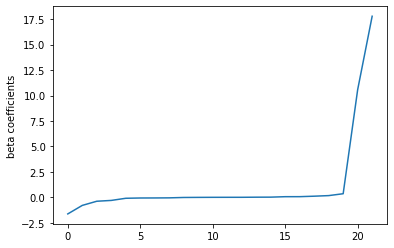

In [48]:
#plotting coefficients
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel("beta coefficients")
plt.show()

In [49]:
print("Intercept: " + str(lrModel.intercept))

Intercept: -2.8442614767155505


Evaluer votre modele score,courbe roc, precision, rappel, etc....

In [50]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

In [51]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.05405405405405406|
|                 0.0|0.10953058321479374|
|                 0.0|0.16358463726884778|
|                 0.0|0.21906116642958748|
|                 0.0|0.27311522048364156|
|                 0.0| 0.3285917496443812|
|                 0.0| 0.3840682788051209|
|                 0.0|0.43812233285917496|
|                 0.0|0.49359886201991465|
|                 0.0| 0.5476529160739687|
|                 0.0| 0.6031294452347084|
|9.982886480319453E-4|  0.647226173541963|
|0.005561893896177981| 0.6571834992887624|
|0.009840273816314889| 0.6699857752489331|
|0.014831717056474614| 0.6742532005689901|
| 0.02010838562464347| 0.6770981507823614|
|0.024957216200798632| 0.6827880512091038|
|0.029806046776953792|  0.689900426742532|
| 0.03451226468910439| 0.6970128022759602|
+----------

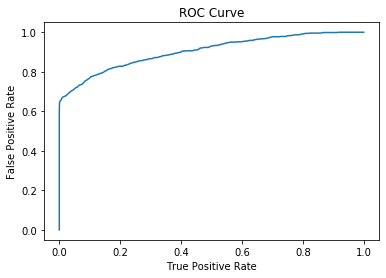

Training set areaUnderROC: 0.9043864247350001


In [52]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [53]:
#Precision and Recall
pr = trainingSummary.pr.show()

+-------------------+------------------+
|             recall|         precision|
+-------------------+------------------+
|                0.0|               1.0|
|0.05405405405405406|               1.0|
|0.10953058321479374|               1.0|
|0.16358463726884778|               1.0|
|0.21906116642958748|               1.0|
|0.27311522048364156|               1.0|
| 0.3285917496443812|               1.0|
| 0.3840682788051209|               1.0|
|0.43812233285917496|               1.0|
|0.49359886201991465|               1.0|
| 0.5476529160739687|               1.0|
| 0.6031294452347084|               1.0|
|  0.647226173541963|0.9848484848484849|
| 0.6571834992887624|0.9221556886227545|
| 0.6699857752489331|0.8722222222222222|
| 0.6742532005689901|0.8200692041522492|
| 0.6770981507823614|0.7714748784440842|
| 0.6827880512091038| 0.732824427480916|
|  0.689900426742532|0.6988472622478387|
| 0.6970128022759602|0.6693989071038251|
+-------------------+------------------+
only showing top

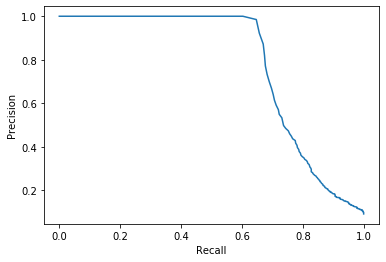

In [54]:
#plotting Precision and Recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

predire alors les clients lowcoast sur un sample de data n'ayant pas servi à l'apprentissage

- ##### Make predictions on the test set

In [55]:
predictions_result = lrModel.transform(testData)

In [56]:
predictions_result.select('ID_CLIENT', 'flg_cmd_lowcostIndex', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+--------------------+--------------------+----------+--------------------+
|           ID_CLIENT|flg_cmd_lowcostIndex|       rawPrediction|prediction|         probability|
+--------------------+--------------------+--------------------+----------+--------------------+
|052f6da65f4a2a4dd...|                 0.0|[4.05777653380142...|       0.0|[0.98300636167207...|
|19c66b854864da37b...|                 0.0|[3.75292798601564...|       0.0|[0.97708826992256...|
|47a423526fcb294f9...|                 0.0|[3.58037820487900...|       0.0|[0.97289025966139...|
|5074f0cc329598ca7...|                 0.0|[2.30250236551066...|       0.0|[0.90908407187742...|
|56a5386ba3979a515...|                 0.0|[2.61886239289428...|       0.0|[0.93206570942109...|
|8e29a807e0c6dec53...|                 0.0|[2.87537564911393...|       0.0|[0.94661565660866...|
|d075a17e7e862d036...|                 0.0|[4.11078815224372...|       0.0|[0.98386960753263...|
|d8472800c7b0aee34...|        

##### Evaluate our Logistic Regression model.

- Evaluation with MulticlassClassificationEvaluator function

In [57]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="flg_cmd_lowcostIndex",predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions_result)*100

In [58]:
accuracy

96.32602655140475

- Score with our compute_score function

In [59]:
manual_score = compute_score(predictions_result,"flg_cmd_lowcostIndex","prediction")

In [60]:
manual_score

96.32602655140475

##### Random Forest

In [61]:
classifier = RandomForestClassifier(labelCol="flg_cmd_lowcostIndex",featuresCol="indexedFeatures",maxDepth=15, numTrees=100)
model_rf = classifier.fit(trainingData)

- ##### Make predictions on the test set

In [62]:
predictions_rf = model_rf.transform(testData)

In [63]:
predictions_rf.select('ID_CLIENT', 'flg_cmd_lowcostIndex', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+--------------------+--------------------+----------+--------------------+
|           ID_CLIENT|flg_cmd_lowcostIndex|       rawPrediction|prediction|         probability|
+--------------------+--------------------+--------------------+----------+--------------------+
|052f6da65f4a2a4dd...|                 0.0|[94.3025114873049...|       0.0|[0.94302511487304...|
|19c66b854864da37b...|                 0.0|[96.9704653891383...|       0.0|[0.96970465389138...|
|47a423526fcb294f9...|                 0.0|[98.9430249001886...|       0.0|[0.98943024900188...|
|5074f0cc329598ca7...|                 0.0|[95.8173344196885...|       0.0|[0.95817334419688...|
|56a5386ba3979a515...|                 0.0|[90.2632692365559...|       0.0|[0.90263269236555...|
|8e29a807e0c6dec53...|                 0.0|[96.6337272876297...|       0.0|[0.96633727287629...|
|d075a17e7e862d036...|                 0.0|[97.9054072874855...|       0.0|[0.97905407287485...|
|d8472800c7b0aee34...|        

- ##### Evaluate our Random Forest model.

- Evaluation with MulticlassClassificationEvaluator function

In [64]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="flg_cmd_lowcostIndex",predictionCol="prediction",metricName="accuracy")

Evaluer soit meme le score en calculant le nombre de VP, FP, VN et FN
on calculera alors le score qui VP+VN/VP+VN+FP+FN
nb: la prediction est automatiquement creee dans le data set et correspond à la colonne prediction

In [65]:
#False Negative
FN = predictions_rf.where("prediction = 1 and flg_cmd_lowcostIndex=0").count()
FN

0

In [66]:
#False Positive
FP = predictions_rf.where("prediction = 0 and flg_cmd_lowcostIndex=1").count()
FP

117

In [67]:
#True Positive
VP = predictions_rf.where("prediction = 1 and flg_cmd_lowcostIndex=1").count()
VP

185

In [68]:
#True Negative
VN = predictions_rf.where("prediction = 0 and flg_cmd_lowcostIndex=0").count()
VN

2937

In [69]:
#Compute Score
Score = (VP+VN)/(VP+VN+FP+FN)
Score*100

96.38777400432232

In [70]:
#Score using MulticlassClassificationEvaluator evaluate function
accuracy = evaluator.evaluate(predictions_rf)*100
accuracy

96.38777400432232

In [71]:
#Compute Score using our Compute_Score function
manual_score = compute_score(predictions_rf,"flg_cmd_lowcostIndex","prediction")
manual_score

96.38777400432232

calculer egalement le rappel et la precision

In [72]:
#Compute recall
recall = VP/(VP+FN)
recall

1.0

In [73]:
#Compute precision
precision = VP/(VP+FP)
precision

0.6125827814569537

In [74]:
#from pyspark.ml.linalg import Vectors
#scoreAndLabels = map(lambda x: (Vectors.dense([1.0 - x[0], x[0]]), x[1]),
#                     [(0.1, 0.0), (0.1, 1.0), (0.4, 0.0), (0.6, 0.0), (0.6, 1.0), (0.6, 1.0), (0.8, 1.0)])
#dataset = spark_session.createDataFrame(scoreAndLabels, ["raw", "label"])
#dataset.head()

#### how to create a spark data frame

In [75]:
from pyspark.sql import Row
import datetime

l = [(datetime.date(2018,1,3), 'Ankit',25,'Fille'),
     (datetime.date(2018,2,3), 'Jalfaizy',22,'Fille'),
     (datetime.date(2018,1,5), 'saurabh',20,'Fille'),
     (datetime.date(2018,1,12), 'Bala',26,'Fille'),
     (datetime.date(2018,7,9), 'Jules',19,'Fille') ,
     (datetime.date(2018,3,18), 'Arild',43,'Garçon'),
     (datetime.date(2018,1,5), 'sarah',20,'Garçon'),
     (datetime.date(2018,8,12), 'Boly',33,'Garçon'),
     (datetime.date(2018,4,6), 'Anita',35,'Garçon'),
     (datetime.date(2018,12,6), 'Jules',22,'Garçon'),
     (datetime.date(2018,7,24), 'Soul',20,'Fille'),
     (datetime.date(2018,6,17), 'Gral',54,'Fille'),
     (datetime.date(2018,9,7), 'Apoh',18,'Fille'),
     (datetime.date(2018,10,4), 'Dony',32,'Fille'),
     (datetime.date(2018,2,5), 'Tanoh',31,'Fille'),
     (datetime.date(2018,11,12), 'Issouf',27,'Garçon'),
     (datetime.date(2018,10,3), 'Bilé',29,'Garçon'),
     (datetime.date(2018,5,3), 'Gagnon',20,'Garçon'),
     (datetime.date(2018,3,5), 'Papiss',28,'Garçon'),
     (datetime.date(2018,2,12), 'Kravitz',34,'Garçon'),
     (datetime.date(2018,5,9), 'Mouli',35,'Fille'),
     (datetime.date(2018,8,3), 'Jacques',27,'Fille'),
     (datetime.date(2018,12,5), 'soum',22,'Fille'),
     (datetime.date(2018,4,12), 'MBra',36,'Fille')]

rdd = spark_session.sparkContext.parallelize(l)
people = rdd.map(lambda x: Row(date=x[0], name=x[1], age=int(x[2]), genre=x[3]))
schemaPeople = spark_session.createDataFrame(people)
schemaPeople.toPandas().head()

,age,date,genre,name
0,25,2018-01-03,Fille,Ankit
1,22,2018-02-03,Fille,Jalfaizy
2,20,2018-01-05,Fille,saurabh
3,26,2018-01-12,Fille,Bala
4,19,2018-07-09,Fille,Jules


In [76]:
#1- Count total number of personn
schemaPeople.count()

24

In [77]:
#2- Count number of girls
schemaPeople[schemaPeople.genre == 'Fille'].count()

14

In [78]:
#2- Count number of boys
schemaPeople[schemaPeople.genre == 'Garçon'].count()

10

In [79]:
#2 We can also count distinct gender with a groupBy expression
schemaPeople.groupBy("genre").agg(f.count('*').alias('nbre')).show()

+------+----+
| genre|nbre|
+------+----+
|Garçon|  10|
| Fille|  14|
+------+----+



In [80]:
#3- What is the mean, median, mini and maxiage in each group(garcon, fille)
DF = schemaPeople.groupBy('genre').agg(f.min('age').alias('minAge'),f.max('age').alias('maxAge'),
                                       f.avg('age').alias('meanAge'),f.count('*').alias('nbre'))

In [81]:
DF.show()

+------+------+------+------------------+----+
| genre|minAge|maxAge|           meanAge|nbre|
+------+------+------+------------------+----+
|Garçon|    20|    43|              29.1|  10|
| Fille|    18|    54|27.642857142857142|  14|
+------+------+------+------------------+----+



In [82]:
#median value
med = schemaPeople.approxQuantile('age',[0.5],0.01)

In [83]:
med[0]

27.0

In [84]:
#median value by sex
G = schemaPeople[schemaPeople.genre=='Garçon'].approxQuantile('age',[0.5],0.01)#median value for the group : Garçon
F = schemaPeople[schemaPeople.genre=='Fille'].approxQuantile('age',[0.5],0.01)#median value for the group : Fille

In [85]:
#adding median values to our table
import pandas as pd
sex_group = pd.DataFrame({'id':['Garçon','Fille'],'median':[G[0],F[0]]})

In [86]:
new_df = pd.concat([DF.toPandas(),sex_group],axis=1)

In [87]:
new_df.drop('id',axis=1)

,genre,minAge,maxAge,meanAge,nbre,median
0,Garçon,20,43,29.100000,10,28.0
1,Fille,18,54,27.642857,14,25.0


In [88]:
from pyspark.sql.functions import mean, min, max
result = schemaPeople.select([mean("age"), min("age"), max("age")])
result.show()

+--------+--------+--------+
|avg(age)|min(age)|max(age)|
+--------+--------+--------+
|   28.25|      18|      54|
+--------+--------+--------+



In [89]:
#4 - what is the date of each customer's last visit compared to today's date
dd = schemaPeople.select("*",
                         f.lit(datetime.date.today()).alias("date_max"))
good_val = dd.select("*", f.datediff('date_max', 'date')\
                    .alias('days_since_last_visit'))#.toPandas()

In [90]:
good_val.show()#.toPandas().head()

+---+----------+------+--------+----------+---------------------+
|age|      date| genre|    name|  date_max|days_since_last_visit|
+---+----------+------+--------+----------+---------------------+
| 25|2018-01-03| Fille|   Ankit|2019-11-03|                  669|
| 22|2018-02-03| Fille|Jalfaizy|2019-11-03|                  638|
| 20|2018-01-05| Fille| saurabh|2019-11-03|                  667|
| 26|2018-01-12| Fille|    Bala|2019-11-03|                  660|
| 19|2018-07-09| Fille|   Jules|2019-11-03|                  482|
| 43|2018-03-18|Garçon|   Arild|2019-11-03|                  595|
| 20|2018-01-05|Garçon|   sarah|2019-11-03|                  667|
| 33|2018-08-12|Garçon|    Boly|2019-11-03|                  448|
| 35|2018-04-06|Garçon|   Anita|2019-11-03|                  576|
| 22|2018-12-06|Garçon|   Jules|2019-11-03|                  332|
| 20|2018-07-24| Fille|    Soul|2019-11-03|                  467|
| 54|2018-06-17| Fille|    Gral|2019-11-03|                  504|
| 18|2018-

In [91]:
#5 - who are persons who have visit date < 400 days.

In [92]:
nbre_personnes = good_val.where(good_val.days_since_last_visit<400)
nbre_personnes.show()

+---+----------+------+------+----------+---------------------+
|age|      date| genre|  name|  date_max|days_since_last_visit|
+---+----------+------+------+----------+---------------------+
| 22|2018-12-06|Garçon| Jules|2019-11-03|                  332|
| 32|2018-10-04| Fille|  Dony|2019-11-03|                  395|
| 27|2018-11-12|Garçon|Issouf|2019-11-03|                  356|
| 29|2018-10-03|Garçon|  Bilé|2019-11-03|                  396|
| 22|2018-12-05| Fille|  soum|2019-11-03|                  333|
+---+----------+------+------+----------+---------------------+



In [93]:
#How many are they?
nbre_personnes.count()

5